In [7]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")
include("LagF.jl")

LagF (generic function with 1 method)

In [9]:
# Two-step Adams Bashforth Scheme (Explicit)

function ab2(f, tspan, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(N + 1, 1)
    y[1] = y0
    k1=h*f(t[1], y[1])
    k2=h*f(t[1]+h, y[1]+k1)
    y[2]=y[1]+0.5*(k1+k2)
    # Two -step AB steps
    for i in 1:(N-1)
        y[i + 2] = y[i + 1] + (3/2) *h* f(t[i+1], y[i+1]) - 0.5 *h* f(t[i], y[i])
    end

    return t, y
end

ab2 (generic function with 1 method)

convergence order = 1.9999747331515352


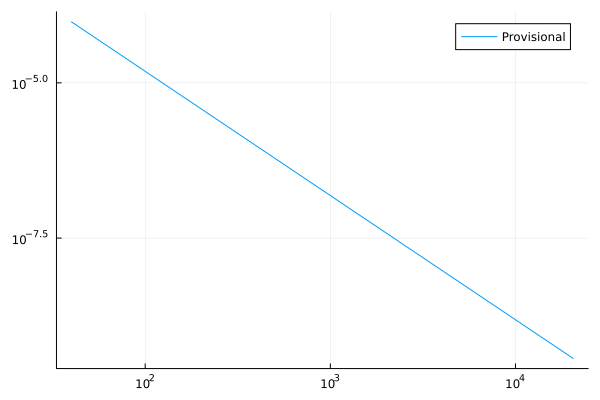

In [3]:
# Convergence Analysis of Adam Bashford 2 method
y0 = 1.0
lambda=-1
tspan=[0 1.0]
K = 10
err = zeros(K, 1)
ns=zeros(K, 1)
for k in 1:K
    N = 20* 2^k
    ns[k]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y) = lambda * y
    (t, y) = ab2(f, tspan, y0, N)
    exact = y0 * exp.(lambda * t)
    
    # Storing errors
    for i in 1:K+1
        err[k] = abs(exact[N+1] .- y[N+1])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, abs.(err), xaxis=:log, yaxis=:log, label="Provisional")
display(plot!(legend=:topright))  # Display the plot

In [4]:
function ridc_ab2(f, tspan, h, y0, N, K)
    
    # Embedding AB-2 into RIDC
    # AB-2 update takes the form 
    # y_(n+1)= y_n + (3/2)*h*f(t_n, y_n) - (1/2)*h*f(t_(n-1), y_(n-1)).
    
    y=zeros(1, N+1, K+1)
    
    t, y[1, :, 1]=ab2(f, tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        y[1, 1, k+1]=y0 # initial condition
        nfval=f(t, y[1, :, k]) # New function value
        
        # (2k+2) equi-spaced nodes are used where k is the iteration number. 
        
        # First step computed by Trapezoidal RK2 (Explicit)
        Qdr=Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[1], t[2]) # Quadrature
        k1= h*(f(t[1], y[1, 1, k+1])- f(t[1], y[1, 1, k]))
        k2= h*(f(t[1] + h, y[1, 1, k+1] + k1 + Qdr) - f(t[1]+h, y[1, 2, k])) 
        
        y[1, 2, k+1]=y[1, 1, k+1] + k1/2 + k2/2 + Qdr
        
        
        
        # First nth steps
        for n in 3:(2*k+1)
            Q= Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-1], t[n])
            b1= (3/2)* h*(f(t[n-1], y[1, n-1, k+1]) - f(t[n-1], y[1, n-1, k]))
            b2= (1/2)* h*(f(t[n-2], y[1, n-2, k+1]) - f(t[n-2], y[1, n-2, k]))
            y[1, n, k+1]= y[1, n-1, k+1] + b1 - b2 + Q
        end
        
        for j in (2*k+2):(N+1)
            Q = Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-1], t[j])
            b1= (3/2)* h*(f(t[j-1], y[1, j-1, k+1]) - f(t[j-1], y[1, j-1, k]))
            b2= (1/2)* h*(f(t[j-2], y[1, j-2, k+1]) - f(t[j-2], y[1, j-2, k]))
            y[1, j, k+1]= y[1, j-1, k+1] + b1 - b2 + Q
        end
            
    end
    return t,  y
end

ridc_ab2 (generic function with 1 method)

convergence order = 1.9807892281704482
convergence order = 3.9588841624949334
convergence order = 6.294693516514544


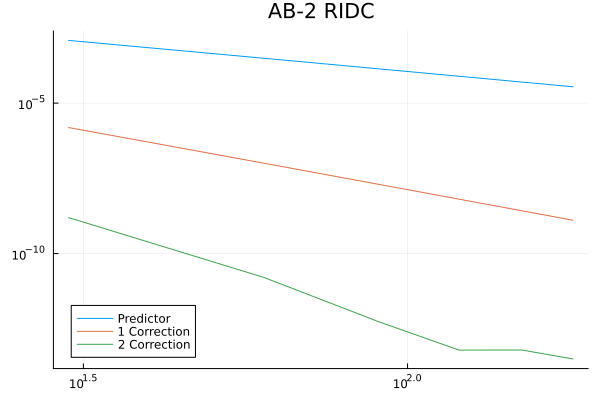

In [7]:
# Example 1: y'=lambda* y, y(0)=1; T in [0, 10]

using Plots
P = 6
y0 = 1.0
lambda= 1
tspan=[0 1]
K = 2
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 30*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y) = lambda * y
    
    (t, y) = ridc_ab2(f, tspan, h, y0, N, K)
    
    exact = y0 * exp.(lambda * t)
   
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n")
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, title="AB-2 RIDC", label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))

convergence order = 2.0241330647164126
convergence order = 4.0339555316215225
convergence order = 6.199790975108162


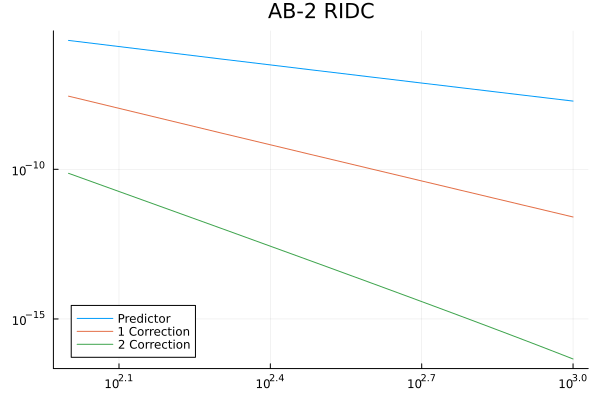

In [8]:
# Example 1: y'=lambda* y, y(0)=1; T in [0, 10]

using Plots
P = 10
y0 = 1.0
lambda= -1
tspan=[0 10]
K = 2
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 100*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y) = lambda * y
    
    (t, y) = ridc_ab2(f, tspan, h, y0, N, K)
    
    exact = y0 * exp.(lambda * t)
   
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n")
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, title="AB-2 RIDC", label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))

convergence order = 1.9828117177838323
convergence order = 4.0045596336178155
convergence order = 6.078002854420896


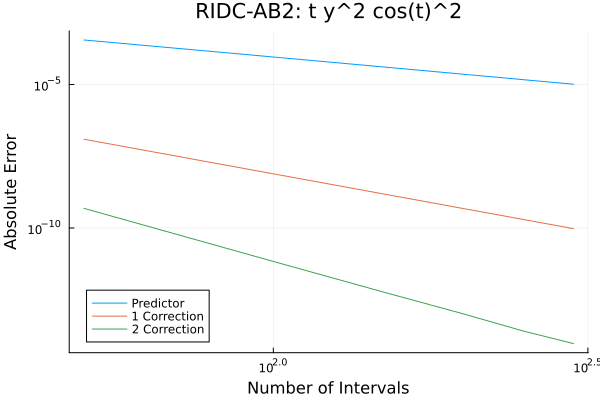

"/Users/sontoshsahani/Draft-Project/Pint-Multistep/RIDC-AB2.png"

In [42]:
# Example 2: y'= t * y^2 * cos.(t)^2, y(0)=1; T in [0, 1]

using Plots
P = 6
y0 = 1.0

tspan=[0 1]
K = 2
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 50*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    
    f(t, y)= t .* y.^2 .* cos.(t) .^2
   
    (t, y) = ridc_ab2(f, tspan, h, y0, N, K)
    
    exact=-8 ./(-9 .+ 2* t.^2 .+ cos.(2*t) .+ 2* t .* sin.(2*t)) 
    
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor", ylabel="Absolute Error", xlabel="Number of Intervals", title="RIDC-AB2: t y^2 cos(t)^2")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))
savefig("RIDC-AB2.png")

convergence order = 1.9896076945595982
convergence order = 3.9728900601647665
convergence order = 5.951051140278679


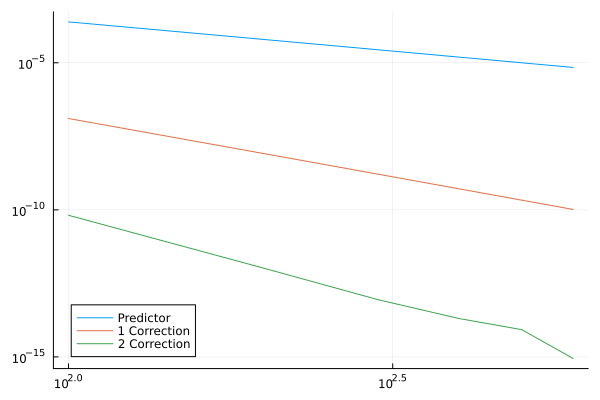

In [12]:
# Example 3: y'=  y^2 , y(0)=1; T in [0, 1/2]

using Plots
P = 6
y0 = 1.0

tspan=[0 1/2]
K = 2
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 100*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y)= y .^2
    (t, y) = ridc_ab2(f, tspan, h, y0, N, K)
    exact= 1 ./ (1 .- t)
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))

convergence order = 2.016595099712512
convergence order = 3.9988517920546953
convergence order = 6.051231547207003


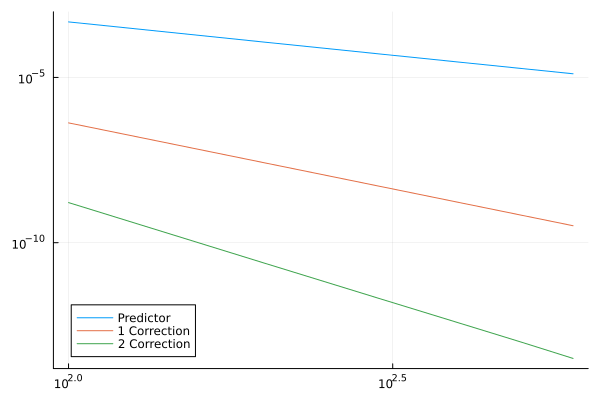

In [13]:
# Example 4: y'= - y .+ sin.(10*t) , y(0)=1; T in [0, 1]

using Plots
P = 6
y0 = 1.0

tspan=[0 1]
K = 2
err = zeros(P, K + 1)
ns=zeros(P, 1)

f(t, y)= - y .+ sin.(10*t)

for p in 1:P
    N = 100*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    
    (t, y) = ridc_ab2(f, tspan, h, y0, N, K)
    exact= -(1/101)* exp.(-t) .*(-111 .+10*exp.(t) .*cos.(10*t).- exp.(t) .*sin.(10*t))
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))

convergence order = 2.0073942059933096
convergence order = 4.018198733621643
convergence order = 6.051617760882031


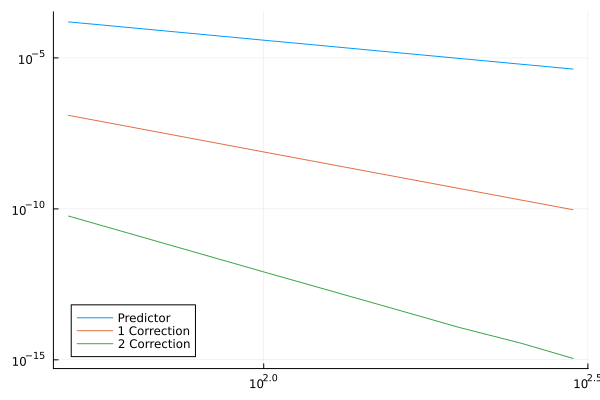

In [15]:
# Example 5: y'= -2* t .* y .^2 , y(0)=1; T in [0, 1]

using Plots
P = 6
y0 = 1.0

tspan=[0 1]
K = 2
err = zeros(P, K + 1)
ns=zeros(P, 1)

f(t, y)= -2* t .* y .^2

exact= 1/2

for p in 1:P
    N = 50*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    
    (t, y) = ridc_ab2(f, tspan, h, y0, N, K)
    
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))

convergence order = 1.984234951302271
convergence order = 3.9744555338205156
convergence order = 5.761704516816131


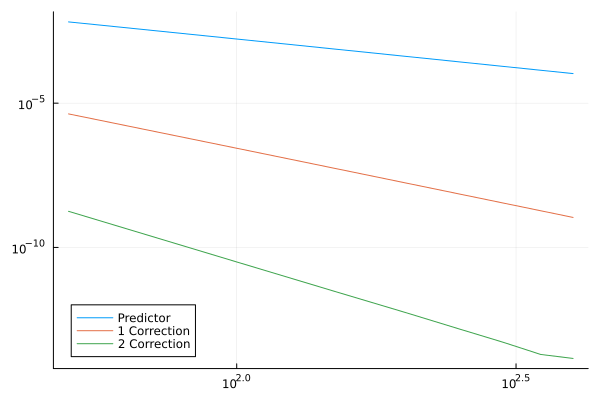

In [16]:
# Example 5: y'= -2* t .* y .^2 , y(0)=1; T in [0, 1]

using Plots
P = 8
y0 = 1.0

tspan=[0 1]
K = 2
err = zeros(P, K + 1)
ns=zeros(P, 1)
f(t, y)= -y .+ exp.(pi .* t)
exact= (exp(pi*tspan[2])+ pi* exp(-tspan[2]))/(1+pi)
for p in 1:P
    N = 50*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    
    (t, y) = ridc_ab2(f, tspan, h, y0, N, K)
    
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))

convergence order = 2.0011703226381474
convergence order = 3.9895655701567048
convergence order = 5.411660944416121


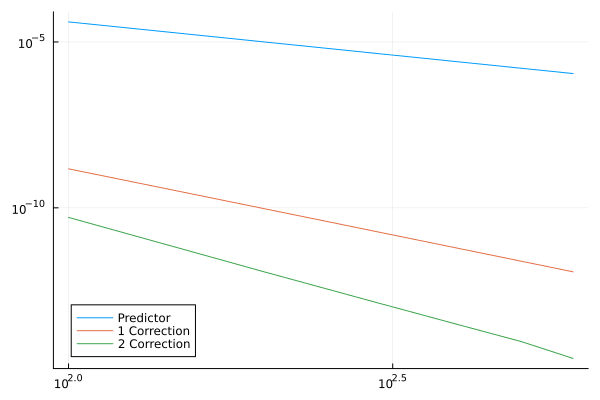

In [20]:
# Example 5: y'= -2* t .* y .^2 , y(0)=1; T in [0, 1]

using Plots
P = 6
y0 = 1.0

tspan=[0 1]
K = 2
err = zeros(P, K + 1)
ns=zeros(P, 1)

f(t, y)= - y .^3  

exact = 1/sqrt(1+2*tspan[2])

for p in 1:P
    N = 100*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
   
    (t, y) = ridc_ab2(f, tspan, h, y0, N, K)
    
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = abs(exact .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))

# RIDC5-AB-23

In [13]:
function ridc5_ab23(f, tspan, y0 , N)
    
 
    K = 1
    
    h = (tspan[2] - tspan[1]) / N
    
    # Embedding AB-2 and AB-3 into RIDC
    
    
    y=zeros(1, N+1, K+1)
    
    t, y[1, :, 1]= ab2(f, tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        
        y[1, 1, k+1]=y0 # initial condition
        
        nfval=f(t, y[1, :, k]) # New function value
        
        # (4k+1) equi-spaced nodes are used where k is the iteration number. 
        
         # First few steps computed by Trapezoidal RK3 (Explicit)
        
       for i=1:2
            
            Q1= Lagrange(t[1:5], nfval[1:5], t[i], t[i]+ 0.5*h)
            
            Q2 = Lagrange(t[1:5], nfval[1:5], t[i], t[i+1])
            
            yhalf = LagF(t[1:5], nfval[1:5], t[i]+ 0.5*h) # Approximating f(t_m+c2*h, y(t_m+c2*h))
            
            k1= h*(f(t[i], y[1, i, k+1]) - f(t[i], y[1, i, k]))
            
            k2= h*(f(t[i]+0.5*h, y[1, i, k+1] + 0.5*k1 + Q1) - yhalf)
            
            k3= h*(f(t[i]+h, y[1, i, k+1] - k1 + 2*k2 + Q2) - f(t[i]+h, y[1, i+1, k]))
            
            y[1, i+1, k+1]= y[1, i, k+1]+ (1/6)*k1 + (2/3)*k2 +(1/6)*k3 + Q2
        end
        
        
        
        
        # Exact starting conditions
        
        #y[1, 2, k+1]= 1/(1 + t[2])
        #y[1, 3, k+1]= 1/(1 +  t[3])
        
        # First nth steps
        for n in 4:(3*k+2)
            Q= Lagrange(t[1:(4*k+1)], nfval[1:(4*k+1)], t[n-1], t[n])
            b1= (23/12)* h*(f(t[n-1], y[1, n-1, k+1]) - f(t[n-1], y[1, n-1, k]))
            b2= (16/12)* h*(f(t[n-2], y[1, n-2, k+1]) - f(t[n-2], y[1, n-2, k]))
            b3= (5/12)* h*(f(t[n-3], y[1, n-3, k+1]) - f(t[n-3], y[1, n-3, k]))
            y[1, n, k+1]= y[1, n-1, k+1] + b1 - b2 + b3 + Q
        end
        
        for j in (4*k+2):(N+1)
            Q = Lagrange(t[j-(4*k+1):j-1], nfval[j-(4*k+1):j-1], t[j-1], t[j])
            b1= (23/12)* h*(f(t[j-1], y[1, j-1, k+1]) - f(t[j-1], y[1, j-1, k]))
            b2= (16/12)* h*(f(t[j-2], y[1, j-2, k+1]) - f(t[j-2], y[1, j-2, k]))
            b3= (5/12)* h*(f(t[j-3], y[1, j-3, k+1]) - f(t[j-3], y[1, j-3, k]))
            y[1, j, k+1]= y[1, j-1, k+1] + b1 - b2 + b3 + Q
        end
            
    end
    return t, y
end

ridc5_ab23 (generic function with 1 method)

convergence order = 2.0303212879242984
convergence order = 4.874961446733213


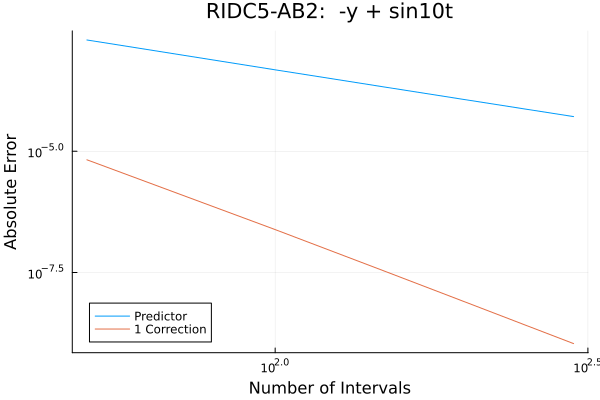

"/Users/sontoshsahani/Draft-Project/Pint-Multistep/RIDC5.png"

In [17]:
# Example 5: y'= -2* t .* y .^2 , y(0)=1; T in [0, 1]

using Plots
P = 6
y0 = 1.0

tspan=[0 1]
K = 1
err = zeros(P, K + 1)
ns=zeros(P, 1)

f(t, y)= - y .+ sin.(10*t)



# Exact Solution

exact = -(1/101)* exp(-tspan[2]) *(-111 +10*exp(tspan[2]) *cos(10*tspan[2])- exp(tspan[2]) *sin(10*tspan[2]))




for p in 1:P
    N = 50*p
    ns[p]=N
   
    (t, y) = ridc5_ab23(f, tspan, y0 , N)
    
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = abs(exact .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction", title="RIDC5-AB2:  -y + sin10t", ylabel="Absolute Error", xlabel="Number of Intervals")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))
savefig("RIDC5.png")

convergence order = 1.982942358252577
convergence order = 4.9395065130714775


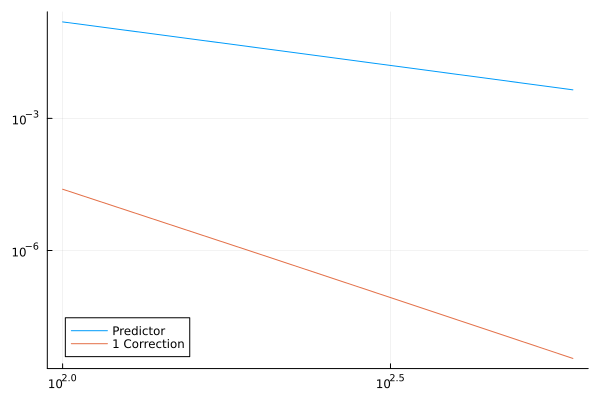

In [30]:
# Example 5: y'= -2* t .* y .^2 , y(0)=1; T in [0, 1]

using Plots
P = 6
y0 = 1.0

tspan=[0 2]
K = 1
err = zeros(P, K + 1)
ns=zeros(P, 1)

f(t, y)= -y .+ exp.(pi .* t)

exact= (exp(pi*tspan[2])+ pi* exp(-tspan[2]))/(1+pi)



for p in 1:P
    N = 100*p
    ns[p]=N
   
    (t, y) = ridc5_ab23(f, tspan, y0 , N)
    
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = abs(exact .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))